Github: https://github.com/wxiExist/RL-game/tree/main

In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class TicTacToeEnv(gym.Env):
    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low=0, high=2, shape=(3, 3), dtype=int)
        self.state = np.zeros((3, 3), dtype=int)
        self.done = False

    def reset(self):
        self.state[:] = 0
        self.done = False
        return self.state

    def step(self, action):
        if self.done or self.state.flat[action] != 0:
            return self.state, 0, self.done, {}

        self.state.flat[action] = 1  #                                           X  ход
        if self._check_winner(1):
            self.done = True
            return self.state, 1, self.done, {}

        if not any(self.state.flat == 0):
            self.done = True
            return self.state, 0, self.done, {}

        #                                                                        (случайным образом)
        opponent_action = np.random.choice(np.where(self.state.flat == 0)[0])
        self.state.flat[opponent_action] = 2
        if self._check_winner(2):
            self.done = True
            return self.state, -1, self.done, {}

        return self.state, 0, self.done, {}

    def _check_winner(self, player):
        for i in range(3):
            if np.all(self.state[i, :] == player) or np.all(self.state[:, i] == player):
                return True
        if self.state[0, 0] == player == self.state[1, 1] == self.state[2, 2]:
            return True
        if self.state[0, 2] == player == self.state[1, 1] == self.state[2, 0]:
            return True
        return False

    def render(self, mode='human'):
        print(self.state)


In [3]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.q_table = np.zeros((3**9, env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay

    def state_to_index(self, state):
        """Преобразование состояния в индекс для Q-таблицы."""
        return int(''.join(map(str, state.flatten())), 3)

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return self.env.action_space.sample()
        state_index = self.state_to_index(state)
        return np.argmax(self.q_table[state_index])

    def learn(self, state, action, reward, next_state):
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index, best_next_action]
        td_error = td_target - self.q_table[state_index, action]
        self.q_table[state_index, action] += self.learning_rate * td_error

    def update_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay


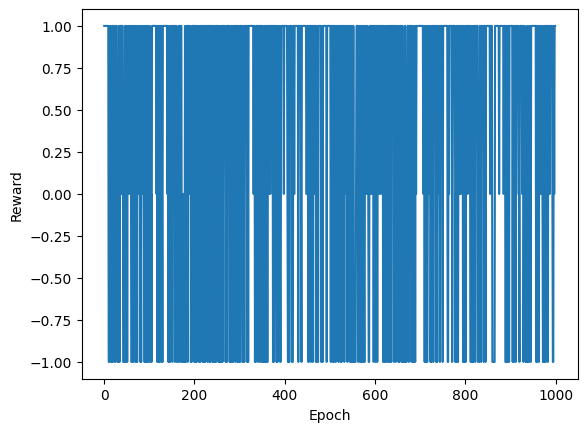

In [5]:
if_dbg = False # Show board while learning

env = TicTacToeEnv()
agent = QLearningAgent(env)

episodes = 1000
rewards = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0


    while True:
        if  if_dbg==True:
          env.reset()
          env.step(0)  # Игрок делает ход в первую клетку
          env.render()  # Выводит текущее состояние поля
          print('-------------')
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state)
        total_reward += reward
        state = next_state

        if done:
            break

    agent.update_exploration_rate()
    rewards.append(total_reward)


plt.plot(rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.show()
